In [4]:
import zipfile
import pandas as pd
import seaborn as sns
import numpy as np
import os
import PIL
import pickle
from PIL import *
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import DenseNet121 # 2017 architecture
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.python.keras import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from keras import optimizers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

**Res-U-Net Explanation**
https://www.kaggle.com/ekhtiar/resunet-a-baseline-on-tensorflow#Loss-Functions

https://towardsdatascience.com/introduction-to-u-net-and-res-net-for-image-segmentation-9afcb432ee2f

In [5]:
brain_df = pd.read_csv('data_mask.csv')

In [6]:
brain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  3929 non-null   object
 1   image_path  3929 non-null   object
 2   mask_path   3929 non-null   object
 3   mask        3929 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 122.9+ KB


In [7]:
brain_df.isnull().sum()

patient_id    0
image_path    0
mask_path     0
mask          0
dtype: int64

In [8]:
brain_df.head() # mask = 0 mean tumor, mask = 1 no tumor

patient_id                                         image_path  \
0  TCGA_CS_5395_19981004  TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif   
1  TCGA_CS_5395_19981004  TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif   
2  TCGA_CS_5395_19981004  TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif   
3  TCGA_CS_5395_19981004  TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif   
4  TCGA_CS_5395_19981004  TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif   

                                           mask_path  mask  
0  TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...     0  
1  TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...     0  
2  TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...     0  
3  TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...     0  
4  TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...     0

In [9]:
brain_df.shape

(3929, 4)

In [10]:
brain_df['mask_path'][0]

'TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_mask.tif'

### MASK
- **What Is Mask?**
    - The goal of image segmentation is to understand image at the pixel level. It associates each pixel with a certian class. The output produced by image segementation model is called **MASK** of the image.
- Mask can be represented by associating pixel values with their coordinates for example it we have a black image of shape (2,2) this can be represented as:
[[0,0],
[0,0]]
- If our output mask is as follows:
[[255,0],
[0,255]]

- To represent this mask we have to first flatten the image into a 1-D array. this would result in something like [255,0,0,255] for mask . then we can use the index to create the mask. finally we would have something like [1,0,0,1] as our mask.

In [11]:
brain_df.mask_path[1]

'TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_mask.tif'

In [12]:
brain_df['mask'].unique()

array([0, 1], dtype=int64)

In [13]:
brain_df['mask'].unique()

array([0, 1], dtype=int64)

In [14]:
brain_df['mask'].value_counts() # no. of rows and cols with 0 and 1

0    2556
1    1373
Name: mask, dtype: int64

In [15]:
brain_df.dtypes

patient_id    object
image_path    object
mask_path     object
mask           int64
dtype: object

In [16]:
import plotly.graph_objects as go
fig = go.Figure([go.Bar(x = brain_df['mask'].value_counts().index, y = brain_df['mask'].value_counts())])
fig.update_traces(marker_color = 'rgb(0,211,0)', marker_line_color = 'rgb(0,0,0)',
                  marker_line_width = 7, opacity = 0.6)
fig.show()

In [17]:
brain_df.mask_path

0       TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...
1       TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...
2       TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...
3       TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...
4       TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...
                              ...                        
3924    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...
3925    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...
3926    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...
3927    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...
3928    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88...
Name: mask_path, Length: 3929, dtype: object

In [18]:
brain_df['mask'].value_counts().index

Int64Index([0, 1], dtype='int64')

In [19]:
brain_df.image_path

0       TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif
1       TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif
2       TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif
3       TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif
4       TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif
                              ...                        
3924    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...
3925    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...
3926    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...
3927    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...
3928    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88...
Name: image_path, Length: 3929, dtype: object

In [20]:
brain_df.mask_path

0       TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...
1       TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...
2       TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...
3       TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...
4       TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...
                              ...                        
3924    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...
3925    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...
3926    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...
3927    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...
3928    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88...
Name: mask_path, Length: 3929, dtype: object

In [21]:
from pathlib import Path

In [22]:
p = Path('./')

In [23]:
folders = list(p.glob('./**'))
folders

[WindowsPath('.'),
 WindowsPath('.ipynb_checkpoints'),
 WindowsPath('TCGA_CS_4941_19960909'),
 WindowsPath('TCGA_CS_4942_19970222'),
 WindowsPath('TCGA_CS_4943_20000902'),
 WindowsPath('TCGA_CS_4944_20010208'),
 WindowsPath('TCGA_CS_5393_19990606'),
 WindowsPath('TCGA_CS_5395_19981004'),
 WindowsPath('TCGA_CS_5396_20010302'),
 WindowsPath('TCGA_CS_5397_20010315'),
 WindowsPath('TCGA_CS_6186_20000601'),
 WindowsPath('TCGA_CS_6188_20010812'),
 WindowsPath('TCGA_CS_6290_20000917'),
 WindowsPath('TCGA_CS_6665_20010817'),
 WindowsPath('TCGA_CS_6666_20011109'),
 WindowsPath('TCGA_CS_6667_20011105'),
 WindowsPath('TCGA_CS_6668_20011025'),
 WindowsPath('TCGA_CS_6669_20020102'),
 WindowsPath('TCGA_DU_5849_19950405'),
 WindowsPath('TCGA_DU_5851_19950428'),
 WindowsPath('TCGA_DU_5852_19950709'),
 WindowsPath('TCGA_DU_5853_19950823'),
 WindowsPath('TCGA_DU_5854_19951104'),
 WindowsPath('TCGA_DU_5855_19951217'),
 WindowsPath('TCGA_DU_5871_19941206'),
 WindowsPath('TCGA_DU_5872_19950223'),
 WindowsP

In [24]:
for x in folders:
    currentFolder = list(x.glob('./**')) # folders
    for y in currentFolder:
        files = list(y.glob('./*'))
        print('FOLDER NAME:'," ", y)
        print(files)
        print()
        
    print()

FOLDER NAME:   .
[WindowsPath('.ipynb_checkpoints'), WindowsPath('classifier-resnet-model.json'), WindowsPath('classifier-resnet-weights.hdf5'), WindowsPath('data.csv'), WindowsPath('data_mask.csv'), WindowsPath('Detecting Brain Tumor Using MRI Scan.ipynb'), WindowsPath('resnet-50-MRI.json'), WindowsPath('ResUNet-model.json'), WindowsPath('ResUNet-MRI.json'), WindowsPath('ResUNet-weights.hdf5'), WindowsPath('TCGA_CS_4941_19960909'), WindowsPath('TCGA_CS_4942_19970222'), WindowsPath('TCGA_CS_4943_20000902'), WindowsPath('TCGA_CS_4944_20010208'), WindowsPath('TCGA_CS_5393_19990606'), WindowsPath('TCGA_CS_5395_19981004'), WindowsPath('TCGA_CS_5396_20010302'), WindowsPath('TCGA_CS_5397_20010315'), WindowsPath('TCGA_CS_6186_20000601'), WindowsPath('TCGA_CS_6188_20010812'), WindowsPath('TCGA_CS_6290_20000917'), WindowsPath('TCGA_CS_6665_20010817'), WindowsPath('TCGA_CS_6666_20011109'), WindowsPath('TCGA_CS_6667_20011105'), WindowsPath('TCGA_CS_6668_20011025'), WindowsPath('TCGA_CS_6669_20020

FOLDER NAME:   TCGA_DU_7306_19930512
[WindowsPath('TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_1.tif'), WindowsPath('TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_10.tif'), WindowsPath('TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_10_mask.tif'), WindowsPath('TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_11.tif'), WindowsPath('TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_11_mask.tif'), WindowsPath('TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_12.tif'), WindowsPath('TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_12_mask.tif'), WindowsPath('TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_13.tif'), WindowsPath('TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_13_mask.tif'), WindowsPath('TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_14.tif'), WindowsPath('TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_14_mask.tif'), WindowsPath('TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_15.tif'), WindowsPath('TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_15_mask.tif'), WindowsPath('TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_16.ti

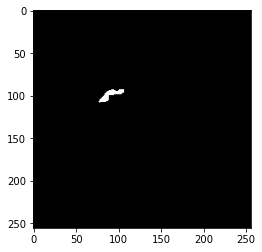

In [25]:
plt.imshow(cv2.imread(brain_df.mask_path[623]))
plt.show()

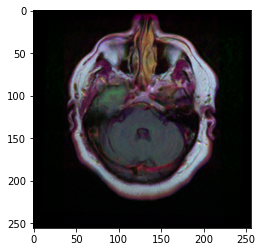

In [26]:
plt.imshow(cv2.imread(brain_df.image_path[623]))
plt.show()

In [27]:
type(brain_df.mask_path[623])

str

In [28]:
brain_df.mask_path[623]

'TCGA_HT_7694_19950404/TCGA_HT_7694_19950404_6_mask.tif'

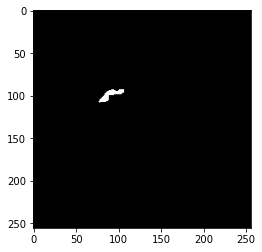

In [29]:
img = cv2.imread(brain_df.mask_path[623])
plt.imshow(img)
plt.show()

In [30]:
img

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [31]:
(img.max(), img.min())

(255, 0)

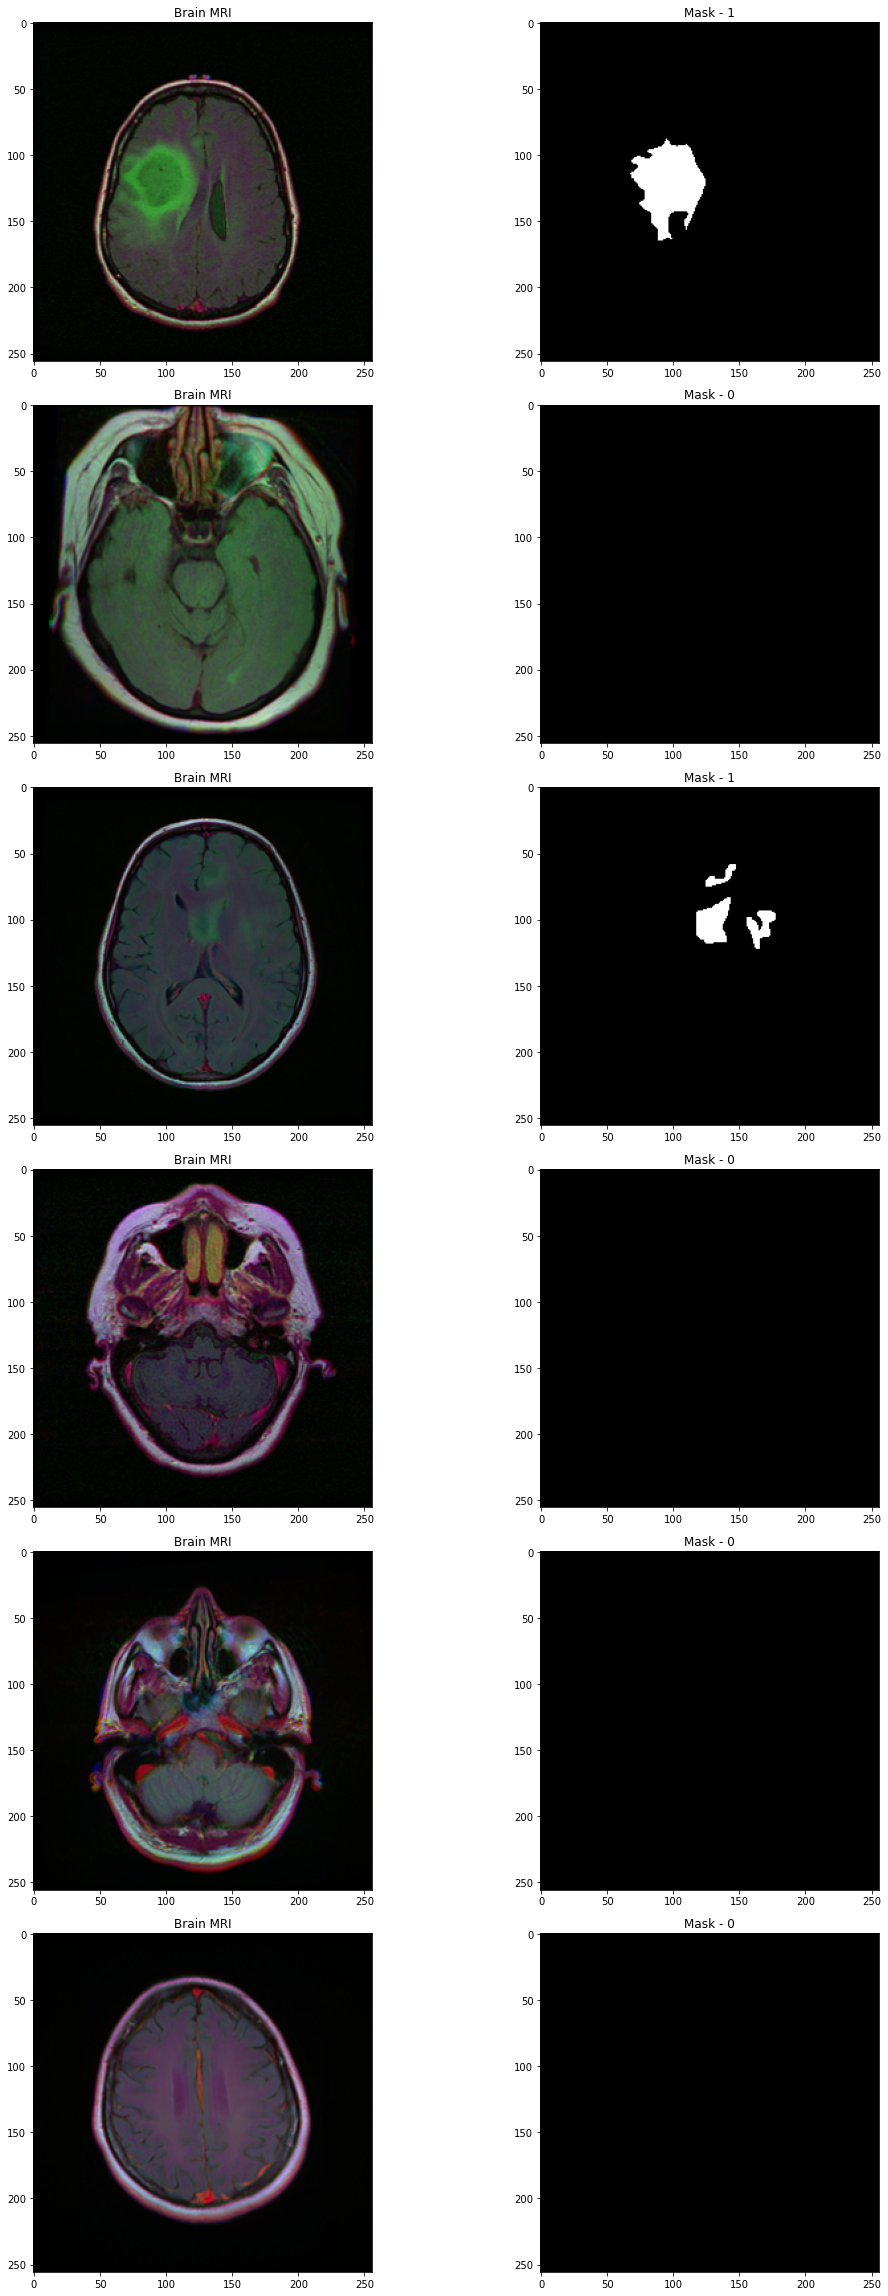

In [32]:
import random
fig, axs = plt.subplots(6,2, figsize=(16,32))
count = 0
for x in range(6):
  i = random.randint(0, len(brain_df))
  axs[count][0].title.set_text("Brain MRI") 
  axs[count][0].imshow(cv2.imread(brain_df.image_path[i])) 
  axs[count][1].title.set_text("Mask - " + str(brain_df['mask'][i])) # plot title on the mask (0 or 1)
  axs[count][1].imshow(cv2.imread(brain_df.mask_path[i])) # Show corresponding mask
  count += 1

fig.tight_layout()

In [33]:
len(brain_df)

3929

In [34]:
brain_df['mask'].unique()

array([0, 1], dtype=int64)

In [35]:
from skimage import io

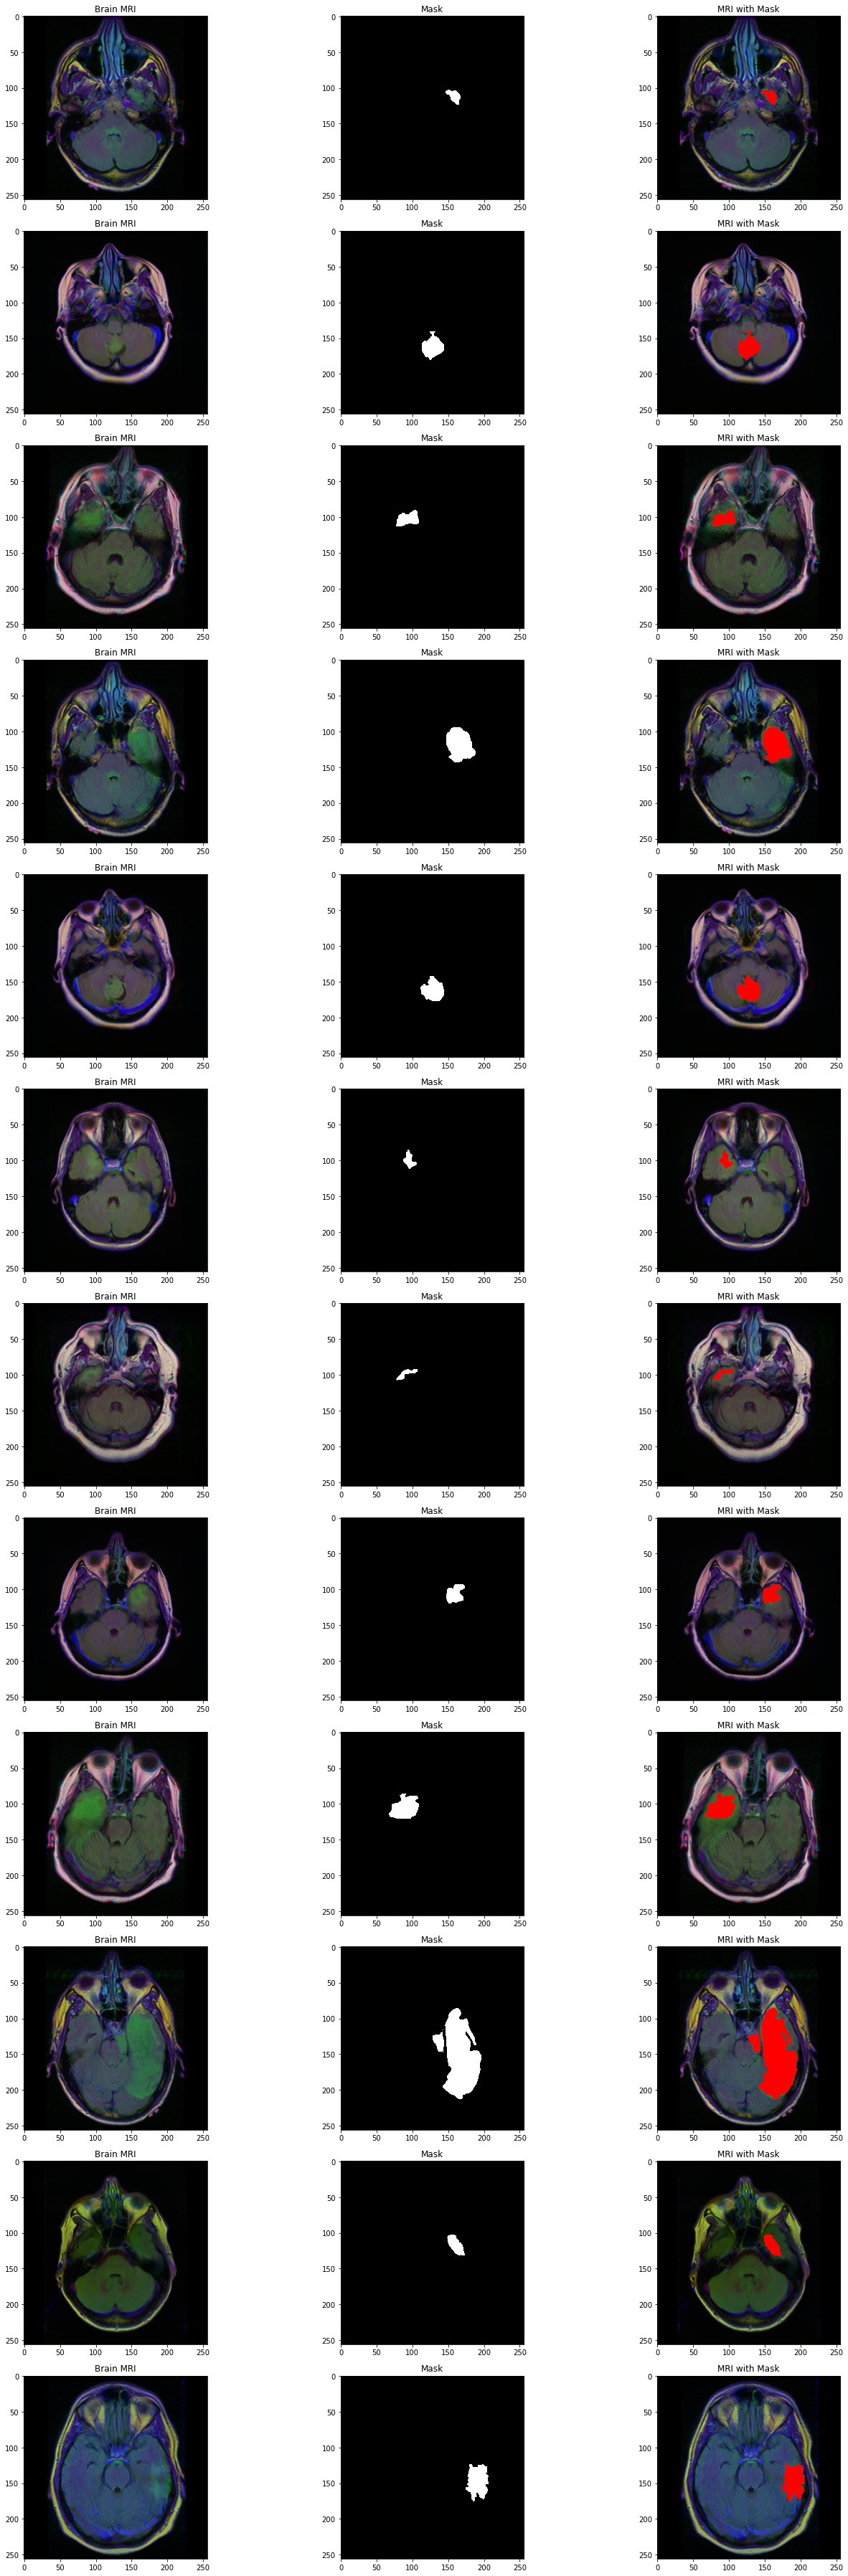

In [36]:
count = 0
fig, axs = plt.subplots(12, 3, figsize = (20, 50))
for i in range(len(brain_df)):
      if brain_df['mask'][i] == 1 and count <12:
        img = io.imread(brain_df.image_path[i])
        axs[count][0].title.set_text('Brain MRI')
        axs[count][0].imshow(img)

        mask = io.imread(brain_df.mask_path[i])
        axs[count][1].title.set_text('Mask')
        axs[count][1].imshow(mask, cmap = 'gray')


        img[mask == 255] = (255, 0, 0) # highlighting tumor
        axs[count][2].title.set_text('MRI with Mask')
        axs[count][2].imshow(img)
        count+=1

fig.tight_layout()


In [37]:
img = io.imread(brain_df.image_path[0])
type(img), len(img)

(numpy.ndarray, 256)

In [38]:
len(img[mask])

256

In [39]:
len(mask)

256

### Training Classifier To Detect If Tumor Exists or Not!

In [40]:
brain_df_training = brain_df.drop(columns=['patient_id'])
brain_df_training.shape

(3929, 3)

In [41]:
# Convert the data in mask column to string format, to use categorical mode in flow_from_dataframe
# You will get this error message if we comment out the this code line:
# TypeError: If class_mode="categorical", y_col="mask" column values must be type string, list or tuple.
brain_df_training['mask'] = brain_df_training['mask'].apply(lambda x: str(x))

In [42]:
brain_df_training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


In [43]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(brain_df_training, test_size = 0.15)

In [44]:
# create a image generator
from keras_preprocessing.image import ImageDataGenerator

# Create a data generator which scales the data from 0 to 1 and makes validation split of 0.15
datagen = ImageDataGenerator(rescale=1./255., validation_split = 0.15)


In [46]:
# https://vijayabhaskar96.medium.com/tutorial-on-keras-flow-from-dataframe-1fd4493d237c
train_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='image_path',
y_col='mask',
subset="training",
batch_size=16,
shuffle=True,
class_mode="categorical",
target_size=(256,256))


valid_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='image_path',
y_col='mask',
subset="validation",
batch_size=16,
shuffle=True,
class_mode="categorical",
target_size=(256,256))

# Create a data generator for test images
test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
dataframe=test,
directory= './',
x_col='image_path',
y_col='mask',
batch_size=16,
shuffle=False,
class_mode='categorical',
target_size=(256,256))



Found 2839 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.
Found 590 validated image filenames belonging to 2 classes.


In [47]:
# Get the ResNet50 base model transfer learning
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256, 256, 3)))

In [48]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [49]:
# freeze the model weights
# freezing weights so that we can make changes 
for layer in basemodel.layers:
      layers.trainable = False

In [137]:
# Add classification head to the base model

headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)#
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
#headmodel = Dense(256, activation = "relu")(headmodel)
#headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(2, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [138]:
# new model summary
model.summary()

Model: "functional_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________

In [139]:
# compilations of model
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics =['accuracy'])

In [140]:
# use early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# save the best model with least validation loss
checkpointer = ModelCheckpoint(filepath="classifier-resnet-weights.hdf5", verbose=1, save_best_only=True)

In [ ]:
history = model.fit(train_generator, steps_per_epoch= train_generator.n // 16, epochs = 1, validation_data= valid_generator, validation_steps= valid_generator.n // 16, callbacks=[checkpointer, earlystopping])

 35/177 [====>.........................] - ETA: 24:23 - loss: 1.4873 - accuracy: 0.6339

In [135]:
# save the model architecture to json file for future use

model_json = model.to_json()
with open("classifier-resnet-model.json","w") as json_file:
      json_file.write(model_json)

In [ ]:
# Load pretrained model (instead of training the model for 1+ hours) 
with open('resnet-50-MRI.json', 'r') as json_file:
    json_savedModel= json_file.read()
# load the model  
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('weights.hdf5')
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

In [ ]:
# make prediction

test_predict = model.predict(test_generator, steps = test_generator.n // 16, verbose =1)

In [58]:
test_predict.shape

(576, 2)

In [59]:
test_predict[0]

array([0.9977558 , 0.00224423], dtype=float32)

In [ ]:
# Obtain the predicted class from the model prediction
predict = []

for i in test_predict:
      predict.append(str(np.argmax(i)))

predict = np.asarray(predict)

In [ ]:
predict

In [ ]:
#since we have used test generator, it limited the images to len(predict), due to batch size
original = np.asarray(test['mask'])[:len(predict)]
len(original)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(original, predict)
accuracy

In [ ]:
# plotting the confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(original, predict)
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot=True)

In [ ]:
from sklearn.metrics import classification_report
report = classification_report(original, predict, labels = [0,1])
print(report)

### Segmentation Model To Localize Tumor

In [122]:
brain_df_mask = brain_df[brain_df['mask'] == 1]
brain_df_mask.shape

(1373, 4)

In [123]:
from sklearn.model_selection import train_test_split
X_train, X_val = train_test_split(brain_df_mask, test_size=0.15)
X_test, X_val = train_test_split(X_val, test_size=0.5)
X_train

patient_id  \
2372  TCGA_FG_A4MT_20020212   
2494  TCGA_FG_A60K_20040224   
2489  TCGA_FG_A60K_20040224   
619   TCGA_DU_5853_19950823   
1973  TCGA_DU_A5TU_19980312   
...                     ...   
2676  TCGA_HT_7616_19940813   
2257  TCGA_FG_7637_20000922   
3419  TCGA_HT_A61B_19991127   
2548  TCGA_HT_7473_19970826   
1603  TCGA_DU_A5TP_19970614   

                                             image_path  \
2372  TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_22...   
2494  TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_24...   
2489  TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_24...   
619   TCGA_HT_7602_19951103/TCGA_HT_7602_19951103_6.tif   
1973  TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_18...   
...                                                 ...   
2676  TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_26...   
2257  TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_21...   
3419  TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_39...   
2548  TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_24...   
1603  TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_15...   

                                              mask_path  mask  
2372  TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_22...     1  
2494  TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_24...     1  
2489  TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_24...     1  
619   TCGA_HT_7602_19951103/TCGA_HT_7602_19951103_6_...     1  
1973  TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_18...     1  
...                                                 ...   ...  
2676  TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_26...     1  
2257  TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_21...     1  
3419  TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_39...     1  
2548  TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_24...     1  
1603  TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_15...     1  

[1167 rows x 4 columns]

In [124]:
#separate list for imageId, classId to pass into the generator
train_ids = list(X_train.image_path)
train_mask = list(X_train.mask_path)
val_ids = list(X_val.image_path)
val_mask= list(X_val.mask_path)
print(train_ids[0])
print(train_mask[0])
print(val_ids[0])
print(val_mask[0])

TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_22.tif
TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_22_mask.tif
TCGA_HT_7855_19951020/TCGA_HT_7855_19951020_12.tif
TCGA_HT_7855_19951020/TCGA_HT_7855_19951020_12_mask.tif


## Custom Datagenerator

In [125]:
#Utilities file contains the code for custom loss function and custom data generator
from utilities import DataGenerator
#create image generators

training_generator = DataGenerator(train_ids,train_mask)
validation_generator = DataGenerator(val_ids,val_mask)

In [ ]:
def resblock(X, f):
  

  # make a copy of input
  X_copy = X

  # main path
  # Read more about he_normal: https://medium.com/@prateekvishnu/xavier-and-he-normal-he-et-al-initialization-8e3d7a087528

  X = Conv2D(f, kernel_size = (1,1) ,strides = (1,1),kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X) 

  X = Conv2D(f, kernel_size = (3,3), strides =(1,1), padding = 'same', kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)

  # Short path
  # Read more here: https://towardsdatascience.com/understanding-and-coding-a-resnet-in-keras-446d7ff84d33

  X_copy = Conv2D(f, kernel_size = (1,1), strides =(1,1), kernel_initializer ='he_normal')(X_copy)
  X_copy = BatchNormalization()(X_copy)

  # Adding the output from main path and short path together

  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [ ]:
# function to upscale and concatenate the values passsed
def upsample_concat(x, skip):
    x = UpSampling2D((2,2))(x)
    merge = Concatenate()([x, skip])

    return merge

In [ ]:
input_shape = (256,256,3)

# Input tensor shape
X_input = Input(input_shape)

# Stage 1
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(X_input)
conv1_in = BatchNormalization()(conv1_in)
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(conv1_in)
conv1_in = BatchNormalization()(conv1_in)
pool_1 = MaxPool2D(pool_size = (2,2))(conv1_in)

# Stage 2
conv2_in = resblock(pool_1, 32)
pool_2 = MaxPool2D(pool_size = (2,2))(conv2_in)

# Stage 3
conv3_in = resblock(pool_2, 64)
pool_3 = MaxPool2D(pool_size = (2,2))(conv3_in)

# Stage 4
conv4_in = resblock(pool_3, 128)
pool_4 = MaxPool2D(pool_size = (2,2))(conv4_in)

# Stage 5 (Bottle Neck)
conv5_in = resblock(pool_4, 256)

# Upscale stage 1
up_1 = upsample_concat(conv5_in, conv4_in)
up_1 = resblock(up_1, 128)

# Upscale stage 2
up_2 = upsample_concat(up_1, conv3_in)
up_2 = resblock(up_2, 64)

# Upscale stage 3
up_3 = upsample_concat(up_2, conv2_in)
up_3 = resblock(up_3, 32)

# Upscale stage 4
up_4 = upsample_concat(up_3, conv1_in)
up_4 = resblock(up_4, 16)

# Final Output
output = Conv2D(1, (1,1), padding = "same", activation = "sigmoid")(up_4)

model_seg = Model(inputs = X_input, outputs = output )


In [ ]:
model_seg.summary()

### Loss function
- We need a custom loss function to train this ResUNet.So, we have used the loss function as it is from https://github.com/nabsabraham/focal-tversky-unet/blob/master/losses.py

In [130]:
from utilities import focal_tversky, tversky_loss, tversky

In [131]:
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky_loss, metrics = [tversky])

In [ ]:
# use early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="ResUNet-weights.hdf5", verbose=1, save_best_only=True)

In [ ]:
history = model_seg.fit(training_generator, epochs = 1, validation_data = validation_generator, callbacks = [checkpointer, earlystopping])

In [ ]:
# save the model architecture to json file for future use

model_json = model_seg.to_json()
with open("ResUNet-model.json","w") as json_file:
  json_file.write(model_json)

In [134]:
from utilities import focal_tversky, tversky_loss, tversky

with open('ResUNet-MRI.json', 'r') as json_file:
    json_savedModel= json_file.read()

# load the model architecture 
model_seg = tf.keras.models.model_from_json(json_savedModel)
model_seg.load_weights('weights_seg.hdf5')
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

In [130]:
# Utilities file contains the code for custom loss function and custom data generator
from utilities import prediction

# making prediction
image_id, mask, has_mask = prediction(test, model, model_seg)

In [131]:
# creating a dataframe for the result
df_pred = pd.DataFrame({'image_path': image_id,'predicted_mask': mask,'has_mask': has_mask})
df_pred

image_path  \
0    TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_10...   
1    TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_52...   
2    TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_34...   
3    TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_29...   
4    TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_17...   
..                                                 ...   
585  TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_4.tif   
586  TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_24...   
587  TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_17...   
588  TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_26...   
589  TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_1.tif   

                                        predicted_mask  has_mask  
0                                              No mask         0  
1                                              No mask         0  
2                                              No mask         0  
3    [[[[7.1303987e-07], [2.4363053e-06], [4.557959...         1  
4                                              No mask         0  
..                                                 ...       ...  
585                                            No mask         0  
586  [[[[8.824976e-07], [3.7905559e-06], [9.990652e...         1  
587                                            No mask         0  
588                                            No mask         0  
589                                            No mask         0  

[590 rows x 3 columns]

In [132]:
# Merge the dataframe containing predicted results with the original test data.
df_pred = test.merge(df_pred, on = 'image_path')
df_pred.head()

image_path  \
0  TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_10...   
1  TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_52...   
2  TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_34...   
3  TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_29...   
4  TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_17...   

                                           mask_path mask  \
0  TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_10...    0   
1  TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_52...    0   
2  TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_34...    0   
3  TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_29...    1   
4  TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_17...    0   

                                      predicted_mask  has_mask  
0                                            No mask         0  
1                                            No mask         0  
2                                            No mask         0  
3  [[[[7.1303987e-07], [2.4363053e-06], [4.557959...         1  
4                                            No mask         0

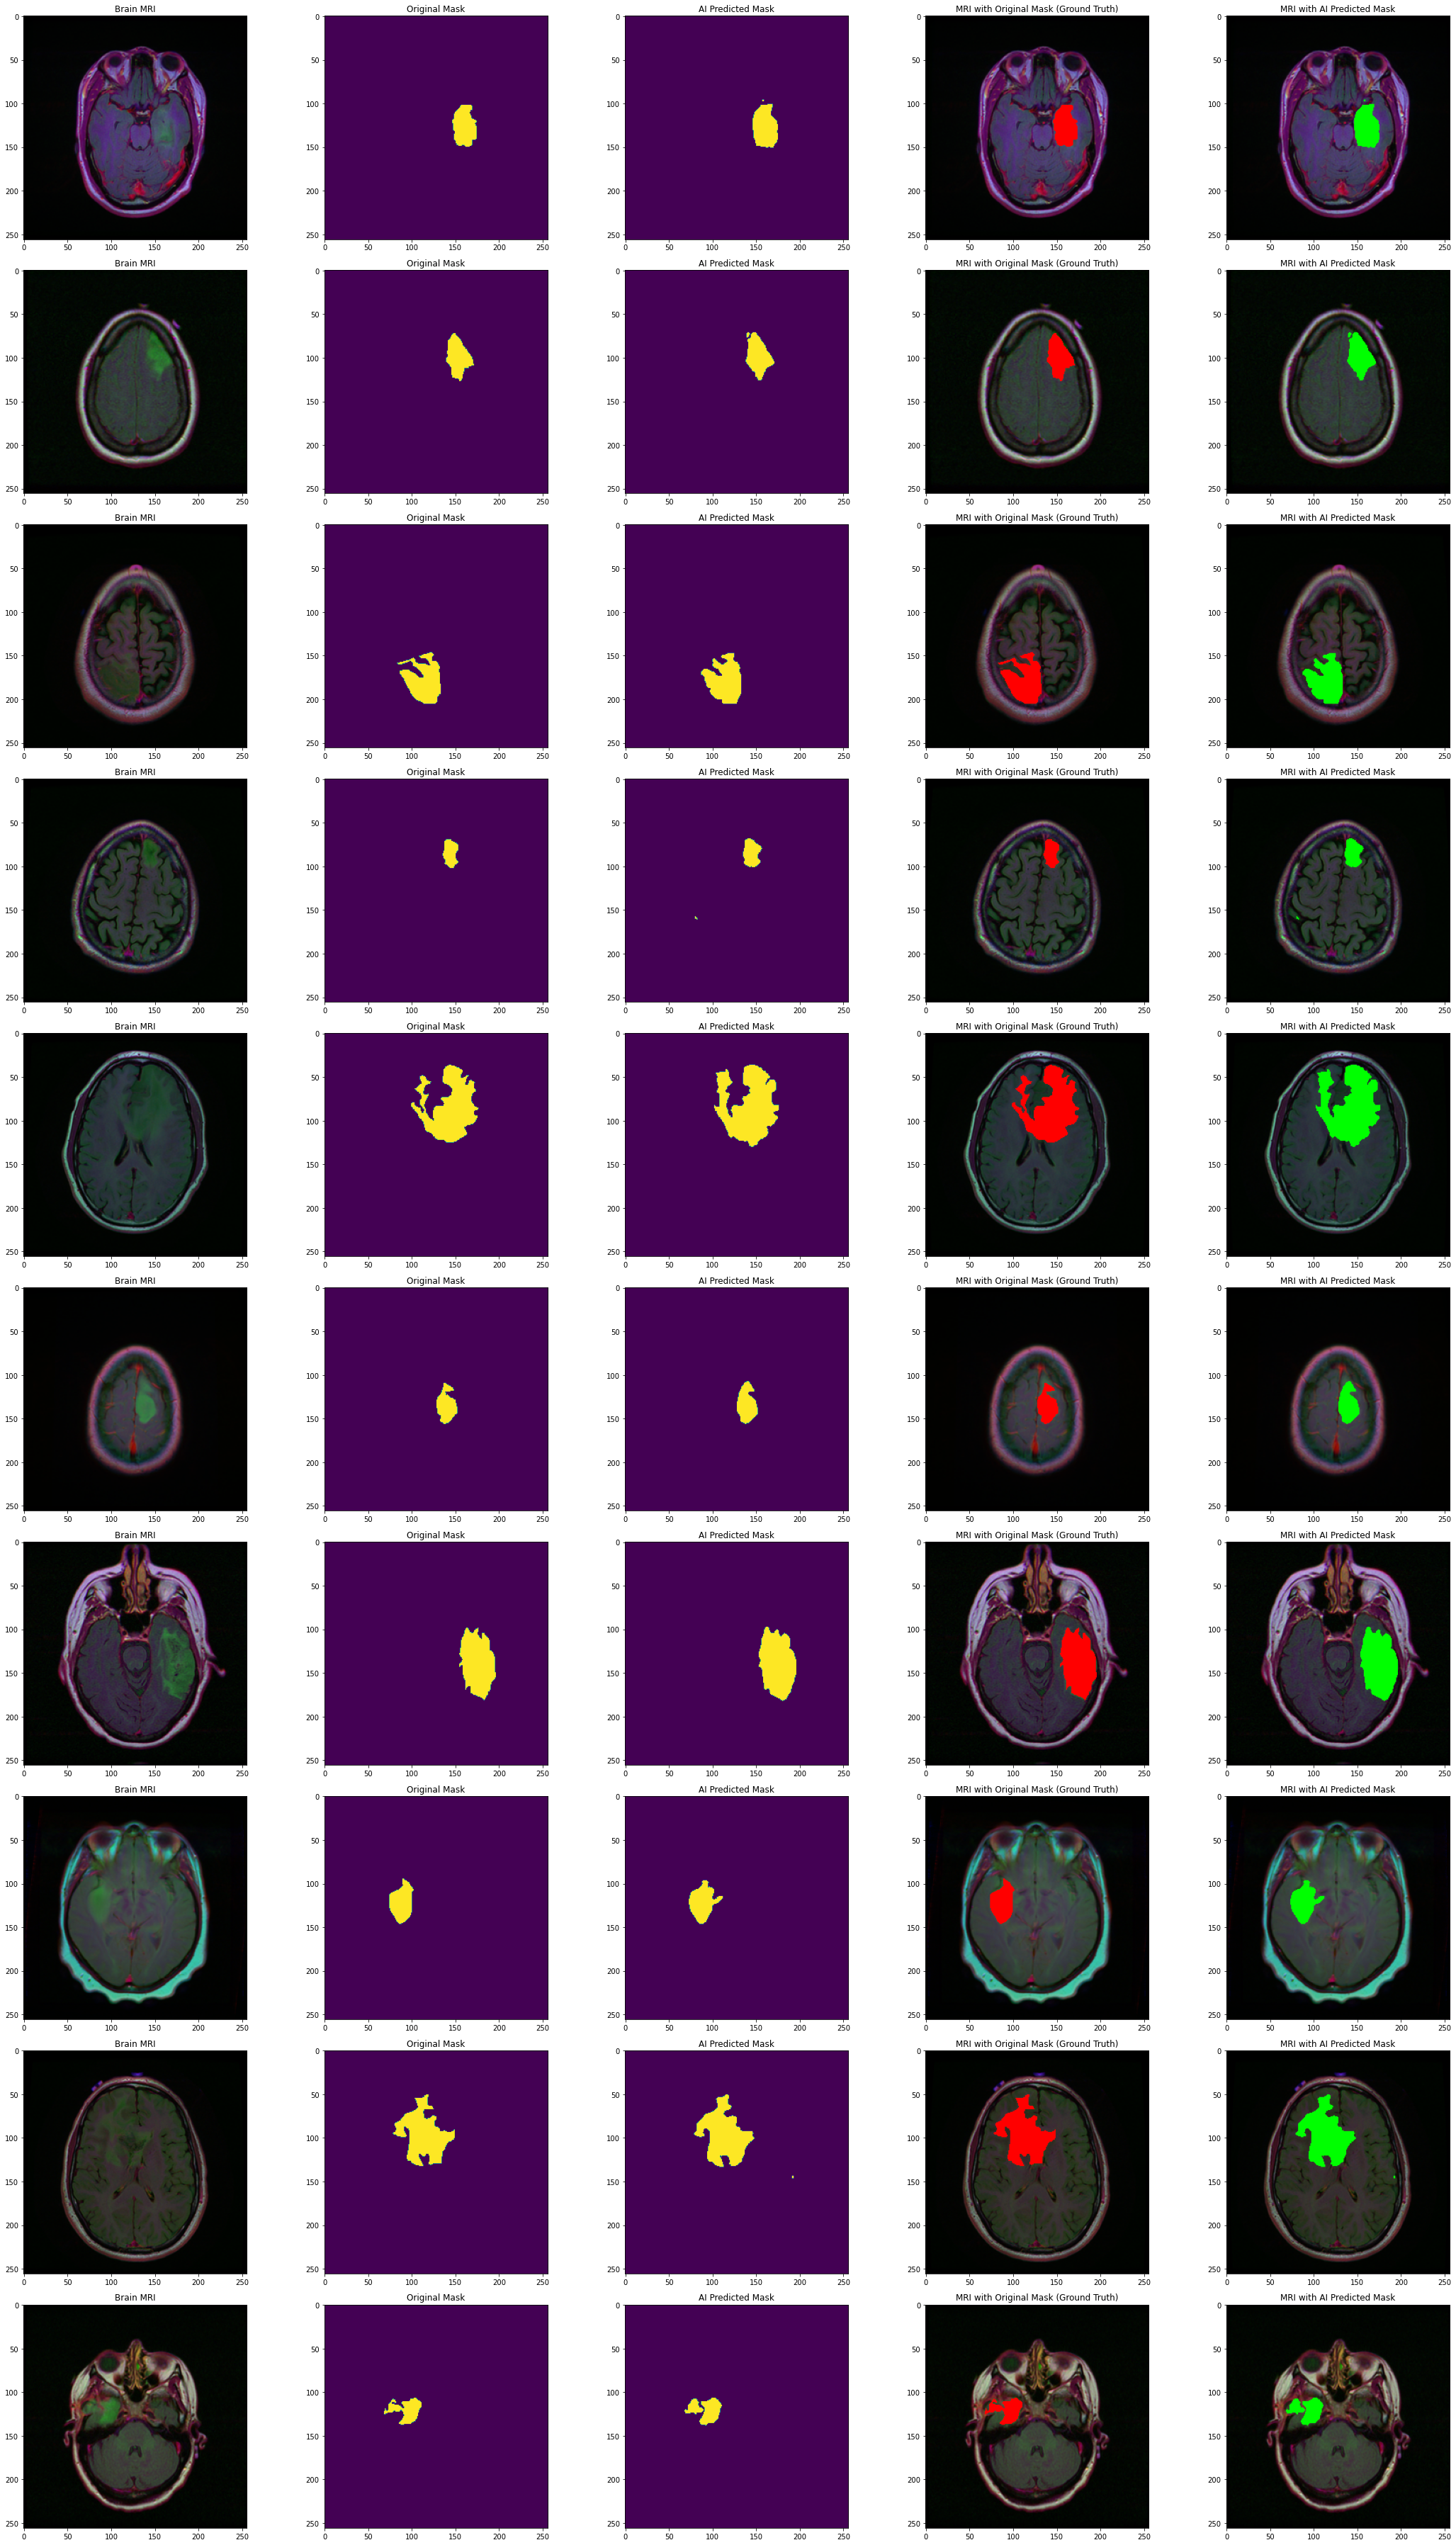

In [133]:
count = 0 
fig, axs = plt.subplots(10, 5, figsize=(30, 50))
for i in range(len(df_pred)):
  if df_pred['has_mask'][i] == 1 and count < 10:
    # read the images and convert them to RGB format
    img = io.imread(df_pred.image_path[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[count][0].title.set_text("Brain MRI")
    axs[count][0].imshow(img)

    # Obtain the mask for the image 
    mask = io.imread(df_pred.mask_path[i])
    axs[count][1].title.set_text("Original Mask")
    axs[count][1].imshow(mask)

    # Obtain the predicted mask for the image 
    predicted_mask = np.asarray(df_pred.predicted_mask[i])[0].squeeze().round()
    axs[count][2].title.set_text("AI Predicted Mask")
    axs[count][2].imshow(predicted_mask)
    
    # Apply the mask to the image 'mask==255'
    img[mask == 255] = (255, 0, 0)
    axs[count][3].title.set_text("MRI with Original Mask (Ground Truth)")
    axs[count][3].imshow(img)

    img_ = io.imread(df_pred.image_path[i])
    img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    img_[predicted_mask == 1] = (0, 255, 0)
    axs[count][4].title.set_text("MRI with AI Predicted Mask")
    axs[count][4].imshow(img_)
    count += 1

fig.tight_layout()